In [1]:
import pandas as pd
import numpy as np
from random import randint

# Preprocessor

In [2]:
pd.read_excel("聽力障礙.xls")

,呼吸窘迫正規化,胎糞吸入正規化,加護病房住院天數,先天性感染正規化,細菌腦膜炎正規化,高膽紅素血症正規化,耳毒性藥物治療大於6天正規化,是否有聽力障礙正規化
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
558,1,0,1,1,0,1,1,1
559,1,1,1,0,0,1,1,1
560,1,1,1,0,0,1,1,1
561,1,0,1,0,0,0,1,1


In [3]:
class Data:
    '''
    存放原始資料之物件
    '''
    def __init__(self, file_name):
        self._data = pd.read_excel(file_name)
        
        self.PSO_data = self._data.drop(columns = ["呼吸窘迫正規化", "先天性感染正規化", "高膽紅素血症正規化"])
        self.CE_data = self._data.drop(columns = ["呼吸窘迫正規化"])


In [4]:
data = Data(file_name= "聽力障礙.xls")
data.PSO_data

,胎糞吸入正規化,加護病房住院天數,細菌腦膜炎正規化,耳毒性藥物治療大於6天正規化,是否有聽力障礙正規化
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
558,0,1,0,1,1
559,1,1,0,1,1
560,1,1,0,1,1
561,0,1,0,1,1


In [5]:
data.CE_data

,胎糞吸入正規化,加護病房住院天數,先天性感染正規化,細菌腦膜炎正規化,高膽紅素血症正規化,耳毒性藥物治療大於6天正規化,是否有聽力障礙正規化
0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
558,0,1,1,0,1,1,1
559,1,1,0,0,1,1,1
560,1,1,0,0,1,1,1
561,0,1,0,0,0,1,1


In [6]:
class ParameterGrid:
    def __init__(self, SVM_data, BPNN_data):
        '''
        網格搜索法的參數網格物件, 需傳入SVM跟BPNN的資料來查看特徵數(欄位數)
        '''
        self._SVM_number_of_features = len(SVM_data.columns) - 1 
        self._BPNN_number_of_features = len(BPNN_data.columns) - 1 
    
    
    @property
    def SVM_ParameterGrid(self):
        '''
        根據SVM資料, 計算出RBF Gamma並設定要進行搜索的參數網格
        '''
        _SVM_RBF_gamma = ((3 / self._SVM_number_of_features) +( 6 / self._SVM_number_of_features)) / 2
        
        parameter_grid = \
        {
        'C' : list(np.arange(1,10.1,0.1)), 
        'gamma': [_SVM_RBF_gamma], 
        'kernel': ['rbf'], 
        'tol':[1e-1, 1e-2,1e-3,1e-4,1e-5,1e-6]
        }
        return parameter_grid
    
    @property
    def BPNN_ParameterGrid(self):
        '''
        根據BPNN的資料, 計算隱藏層所需的神經元個數,並設定要進行搜索的參數網格
        分為: 
        總合法(特徵數+2)
        平均法(特徵數+2) / 2
        加倍法(特徵數+2) * 2
             
        '''
        
        total_method_neurons = (self._BPNN_number_of_features + 2);#2 represents the number of outcomes trying to predict.
        mean_method_neurons = (self._BPNN_number_of_features + 2) // 2;
        double_method_neurons = (self._BPNN_number_of_features + 2) * 2;
        
        
        parameter_grid = \
        {
        'hidden_layer_sizes' : [mean_method_neurons,total_method_neurons,double_method_neurons], #隱藏層神經元個數 
        'solver':['sgd'],
        'learning_rate': ['constant'],
        'learning_rate_init' : list(np.arange(0.1,1.1, 0.1)),
         'random_state' : [1],
        'alpha': list(np.arange(0.1,1.1, 0.1))
        }
        
        return parameter_grid
    
    def __str__(self):
        '''
        使用__str__魔法方法來印出易懂的參數網格
        '''
        round_func = (lambda value: round(value, 2))
        learning_rate = list(map(round_func,self.BPNN_ParameterGrid['learning_rate_init']) )
        alpha = list(map(round_func,self.BPNN_ParameterGrid['alpha']) )
        
        C = list(map(round_func, self.SVM_ParameterGrid['C']) )
        
        summary = f"BPNN 參數設定 \t \n{self._BPNN_number_of_features}個預測因子 \n" + \
                  f"\t 隱藏層神經元個數: {self.BPNN_ParameterGrid['hidden_layer_sizes']} \n" + \
                  f"\t 演算法: {self.BPNN_ParameterGrid['solver'][0]} \n" + \
                  f"\t 學習速率: {learning_rate} \n" + \
                  f"\t L2 正則化參數(懲罰函數): {alpha} \n\n" + \
                  f"SVM 參數設定 \t \n{self._SVM_number_of_features}個預測因子\n" + \
                  f"\t C 正則化參數(懲罰函數): {C[0]}～{C[-1]} 區間: {round(C[1] - C[0], 2)} \n" + \
                  f"\t Gamma {self.SVM_ParameterGrid['gamma']} \n" + \
                  f"\t Kernal: {self.SVM_ParameterGrid['kernel']} \n" + \
                  f"\t 終止條件: {self.SVM_ParameterGrid['tol']}"
        return summary
    
    
    
    
    
    
    

In [7]:
parameter_grid = ParameterGrid(SVM_data=data.PSO_data, 
                               BPNN_data=data.CE_data)
print(parameter_grid)

BPNN 參數設定 	 
6個預測因子 
	 隱藏層神經元個數: [4, 8, 16] 
	 演算法: sgd 
	 學習速率: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
	 L2 正則化參數(懲罰函數): [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 

SVM 參數設定 	 
4個預測因子
	 C 正則化參數(懲罰函數): 1.0～10.0 區間: 0.1 
	 Gamma [1.125] 
	 Kernal: ['rbf'] 
	 終止條件: [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]


In [8]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
class MachineLearningModel:
    '''
    機器學習模型存放工廠 (SVM及BPNN)
    '''
    SVM = SVC(probability= True,random_state= randint(1, 1000))
    BPNN = MLPClassifier(random_state=randint(1, 1000))    

In [9]:
print(MachineLearningModel.SVM)
print(MachineLearningModel.BPNN)

SVC(probability=True, random_state=262)
MLPClassifier(random_state=279)


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix ,accuracy_score
import matplotlib.pyplot as plt
plt.style.use("seaborn")
class GridSearchModel:
    '''
    網格搜索模型, 共有兩個模型 (SVM, BPNN)
    模型的建立,需傳入資料(Data_obj), 跟網格的參數(Grid_obj)
    預設10疊交叉驗證, 衡量指標設為ROC-AUC.
    
    '''
    def __init__(self,Data_obj, Grid_obj, cv = 10):
        self.Data_obj = Data_obj
        self._SVM_grid = GridSearchCV(estimator= MachineLearningModel.SVM,
                                    param_grid= Grid_obj.SVM_ParameterGrid,
                                    cv= cv,
                                    scoring= ["accuracy", "roc_auc"], 
                                    verbose= 3, 
                                    n_jobs= -1, 
                                    refit= "roc_auc",
                                    return_train_score= True)
        
        self._BPNN_grid = GridSearchCV(estimator= MachineLearningModel.BPNN,
                                    param_grid= Grid_obj.BPNN_ParameterGrid,
                                    cv= cv,
                                    scoring= ["accuracy", "roc_auc"], 
                                    verbose= 3, 
                                    n_jobs= -1, 
                                    refit= "roc_auc",
                                    return_train_score= True)
        
        self._SVM_trained_flag = False
        self._BPNN_trained_flag = False
        
    @property
    def SVM_grid(self):
        '''
        回傳SVM網格模型
        '''
        return self._SVM_grid
    @property
    def BPNN_grid(self):
        '''
        回傳BPNN網格模型
        '''
        return self._BPNN_grid
    
    
    def training_SVM(self, predictee, test_size = 0.2, random_state = randint(1, 1000)):
        '''
        訓練SVM, 需傳入想預測之因子,
        預設80%訓練, 20%測試
        '''
        #資料分割
        X = self.Data_obj.PSO_data.drop(columns = predictee);
        y = self.Data_obj.PSO_data[predictee]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify= y)
        
        self.SVM_X_test = X_test
        self.SVM_y_test = y_test
        
        
        self._SVM_grid.fit(X_train, y_train);
        #self._SVM_pred = self._SVM_grid.predict(X_test)
        
        self._SVM_trained_flag = True
        
        
    def training_BPNN(self, predictee, test_size = 0.2, random_state = randint(1, 1000)):
        '''
        訓練BPNN, 需傳入想預測之因子,
        預設80%訓練, 20%測試
        '''
        #資料分割
        X = self.Data_obj.CE_data.drop(columns = predictee);
        y = self.Data_obj.CE_data[predictee]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify= y)
        
        self.BPNN_X_test = X_test
        self.BPNN_y_test = y_test
        
        
        
        self._BPNN_grid.fit(X_train, y_train);
        
        
        self._BPNN_trained_flag = True
    @property
    def training_report(self):
        '''
        回傳最佳模型參數, 精準度,ROC-AUC曲線及繪製出混亂矩陣
        '''
        if self._training_status_checker: # 檢查模型是否已訓練:
            fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (20 ,20), dpi = 300)
            axes = axes.flatten()
            ### ROC Curve ###
            plot_roc_curve(self._BPNN_grid.best_estimator_, self.BPNN_X_test, self.BPNN_y_test, 
                           ax= axes[0])
            axes[0].set_title("BPNN AURC", fontsize = 20)
            plot_roc_curve(self._SVM_grid.best_estimator_, self.SVM_X_test, self.SVM_y_test, 
                           ax= axes[1])
            axes[1].set_title("SVM AURC", fontsize = 20)
            plot_confusion_matrix(self._BPNN_grid.best_estimator_, self.BPNN_X_test, self.BPNN_y_test, 
                                  ax= axes[2], cmap = "Blues")
            
            ### 混亂矩陣 ###
            axes[2].set_title("BPNN Confusion Matrix", fontsize = 20)
            plot_confusion_matrix(self._SVM_grid.best_estimator_, self.SVM_X_test, self.SVM_y_test, 
                                  ax= axes[3], cmap = "Blues")
            axes[3].set_title("SVM Confusion Matrix", fontsize = 20)
            
            axes[2].grid(False)
            axes[3].grid(False)
            
            #預測結果
            self._BPNN_pred = self._BPNN_grid.predict(self.BPNN_X_test)
            self._SVM_pred = self._SVM_grid.predict(self.SVM_X_test)
            
            #準確度及最佳模型變數
            bpnn_acc = accuracy_score(self._BPNN_pred, self.BPNN_y_test)
            bpnn_best_estimator = self._BPNN_grid.best_estimator_
            svm_acc = accuracy_score(self._SVM_pred, self.SVM_y_test)
            svm_best_estimator = self._SVM_grid.best_estimator_
            
            print(f"BPNN準確度: {bpnn_acc}")
            print(f"BPNN 最佳模型: {bpnn_best_estimator}")
            print(f"SVM準確度: {svm_acc}")
            print(f"SVM 最佳模型: {svm_best_estimator}")

    def cv_results(self):
        '''
        輸出GridSearchCV內的屬性(cv_results_)並以DataFrame的方式呈現
        '''
        if self._training_status_checker: # 檢查模型是否已訓練:
            svm_cv_result = pd.DataFrame(self._SVM_grid.cv_results_)
            bpnn_cv_result = pd.DataFrame(self._BPNN_grid.cv_results_)
            return dict(SVM = svm_cv_result, BPNN = bpnn_cv_result)
        else:
            raise NotImplementedError("模型尚未訓練")
            
            
            
    
    
    def _training_status_checker(self):
        '''
        檢查模型是否已訓練完成
        '''
        checker = ((self._SVM_trained_flag) & (self._BPNN_trained_flag))
        
        return checker
        
        
        
        
    
        

# 網格搜索模型建立

In [11]:
Grid_Search_model = GridSearchModel(Data_obj=data, 
                                    Grid_obj= parameter_grid,cv = 10)

# 模型訓練

In [12]:
Grid_Search_model.training_SVM(predictee="是否有聽力障礙正規化")
Grid_Search_model.training_BPNN(predictee="是否有聽力障礙正規化")

Fitting 10 folds for each of 546 candidates, totalling 5460 fits
Fitting 10 folds for each of 300 candidates, totalling 3000 fits


# 模型表現

BPNN準確度: 0.9203539823008849
BPNN 最佳模型: MLPClassifier(alpha=0.8, hidden_layer_sizes=8,
              learning_rate_init=0.7000000000000001, random_state=1,
              solver='sgd')
SVM準確度: 0.911504424778761
SVM 最佳模型: SVC(C=2.7000000000000015, gamma=1.125, probability=True, random_state=262,
    tol=1e-06)


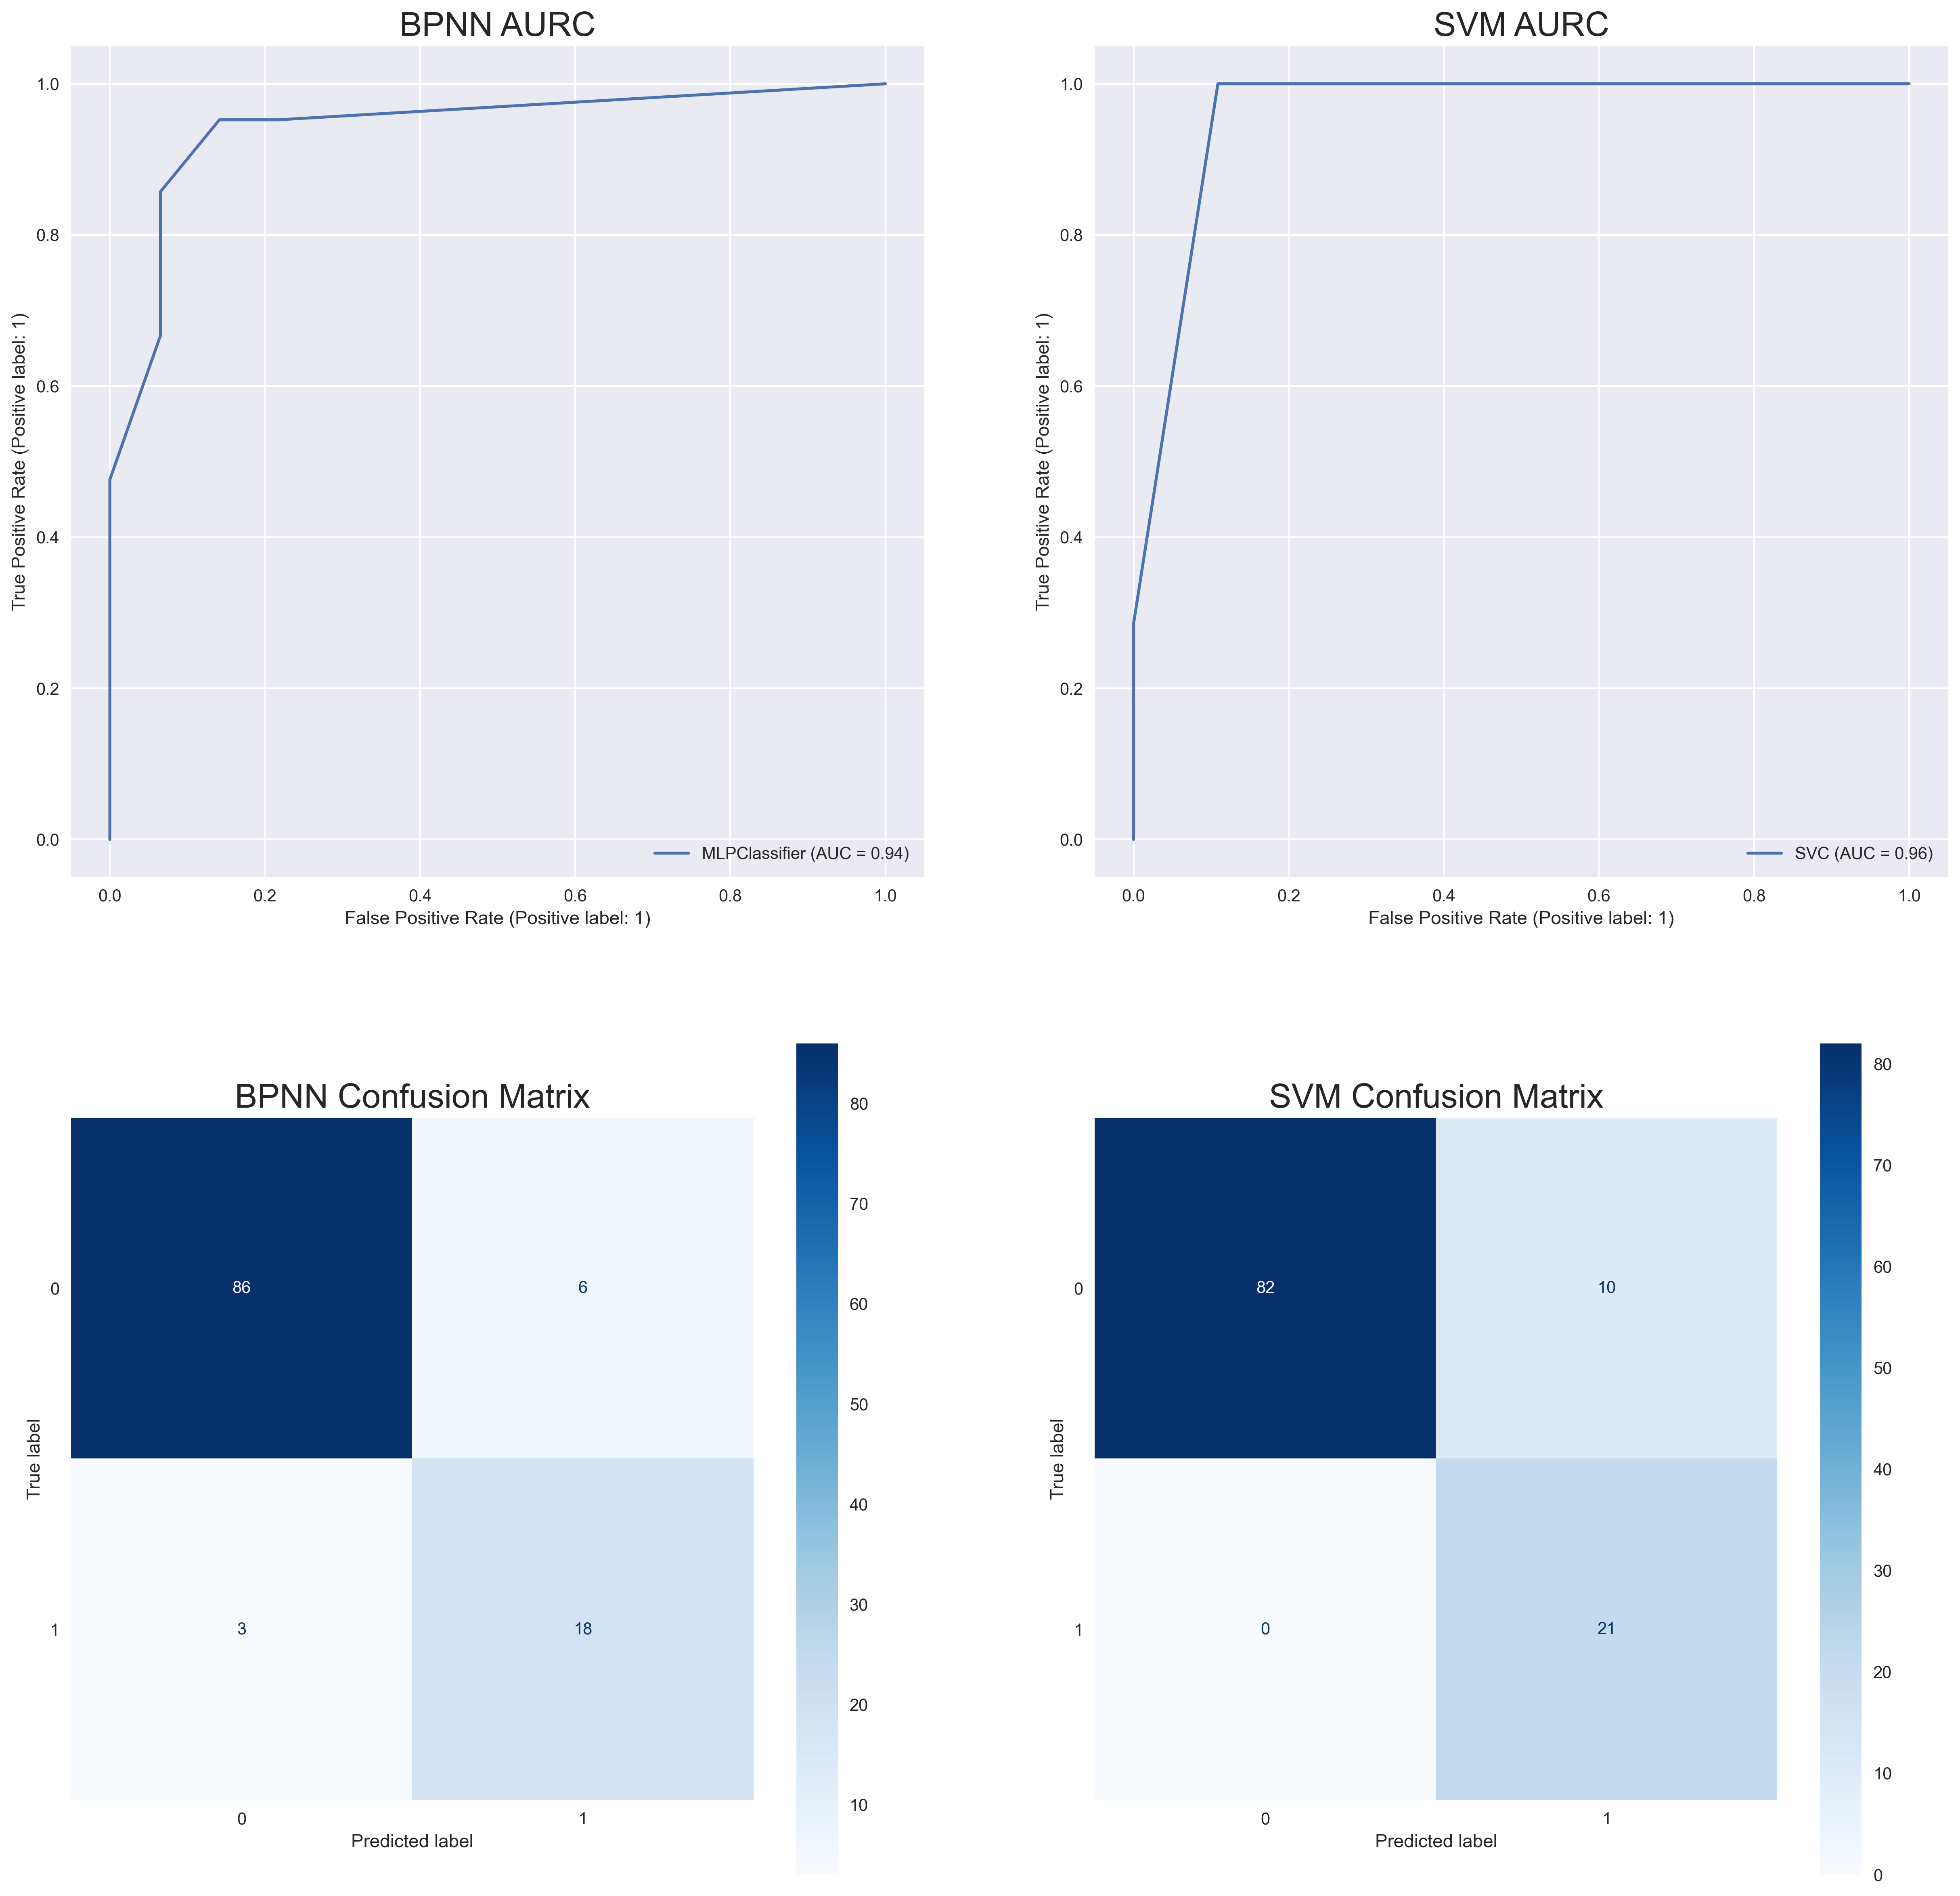

In [13]:
Grid_Search_model.training_report

In [14]:
pd.set_option("display.max_columns", None)
cv_obj = Grid_Search_model.cv_results()

# 訓練結果產出

In [15]:
class TrainingResult:
    def __init__(self, cv_obj):
        self.data = cv_obj
        
        self.svm = self.data["SVM"]
        self.bpnn = self.data["BPNN"]
    

In [16]:
pivot_report = TrainingResult(cv_obj= cv_obj)
pivot_report.bpnn

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_random_state,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,split5_test_roc_auc,split6_test_roc_auc,split7_test_roc_auc,split8_test_roc_auc,split9_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,split5_train_roc_auc,split6_train_roc_auc,split7_train_roc_auc,split8_train_roc_auc,split9_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
0,0.108809,0.038320,0.014461,0.015669,0.1,4,constant,0.1,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 4, 'learn...",0.911111,0.977778,0.977778,0.977778,0.955556,0.911111,0.955556,0.955556,0.888889,0.977778,0.948889,0.031505,1,0.953086,0.950617,0.948148,0.950617,0.953086,0.958025,0.953086,0.950617,0.958025,0.950617,0.952593,0.003084,0.984797,0.991554,0.991554,0.994932,0.989865,0.951014,0.983108,0.983108,0.961420,0.993827,0.982518,0.013939,32,0.985895,0.981424,0.981016,0.980710,0.981220,0.984894,0.981894,0.982057,0.987250,0.980896,0.982725,0.002251
1,0.082222,0.033975,0.008481,0.002965,0.1,4,constant,0.2,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 4, 'learn...",0.933333,0.888889,0.933333,0.911111,0.955556,0.911111,0.955556,0.955556,0.888889,0.977778,0.931111,0.028889,36,0.953086,0.911111,0.906173,0.908642,0.938272,0.955556,0.950617,0.950617,0.958025,0.948148,0.938025,0.019890,0.984797,0.991554,0.991554,0.994932,0.989865,0.951014,0.969595,0.983108,0.961420,0.993827,0.981167,0.014461,130,0.983608,0.983343,0.983016,0.982628,0.981220,0.984894,0.981812,0.981118,0.985105,0.980896,0.982764,0.001437
2,0.064418,0.018058,0.007315,0.001175,0.1,4,constant,0.3,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 4, 'learn...",0.933333,0.888889,0.933333,0.977778,0.933333,0.866667,0.955556,0.955556,0.888889,0.977778,0.931111,0.036447,36,0.953086,0.908642,0.898765,0.935802,0.903704,0.901235,0.950617,0.950617,0.958025,0.948148,0.930864,0.023398,0.984797,0.991554,0.991554,0.994932,0.983108,0.951014,0.983108,0.983108,0.961420,0.993827,0.981842,0.013728,80,0.985895,0.983343,0.983016,0.980873,0.984078,0.984853,0.981975,0.982261,0.985270,0.983000,0.983456,0.001493
3,0.055999,0.010732,0.006609,0.000660,0.1,4,constant,0.4,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 4, 'learn...",0.933333,0.888889,0.888889,0.933333,0.955556,0.866667,0.955556,0.955556,0.888889,0.977778,0.924444,0.036107,52,0.955556,0.898765,0.898765,0.888889,0.933333,0.901235,0.950617,0.953086,0.911111,0.950617,0.924198,0.025566,0.984797,0.991554,0.991554,0.994932,0.989865,0.951014,0.969595,0.983108,0.961420,0.993827,0.981167,0.014461,130,0.985895,0.981302,0.981016,0.979730,0.980118,0.984853,0.981975,0.982179,0.985270,0.981061,0.982340,0.002096
4,0.051708,0.010772,0.006313,0.000908,0.1,4,constant,0.5,1,sgd,"{'alpha': 0.1, 'hidden_layer_sizes': 4, 'learn...",0.844444,0.977778,0.888889,0.977778,0.955556,0.888889,0.933333,0.955556,0.888889,0.888889,0.920000,0.043546,65,0.903704,0.935802,0.893827,0.935802,0.950617,0.945679,0.940741,0.953086,0.955556,0.911111,0.932593,0.020807,0.984797,0.991554,0.991554,0.994932,0.983108,0.951014,0.969595,0.966216,0.955247,0.993827,0.978184,0.015595,213,0.983608,0.981261,0.980893,0.980791,0.972687,0.983955,0.981975,0.974545,0.986920,0.980855,0.980749,0.004023
...,...,...,...,...,...,...,

# SVM

# 準確度

In [17]:
pd.pivot_table(data= pivot_report.svm, columns= "param_C", 
               index = "param_tol", 
               values = "mean_test_accuracy")

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
0.000010,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
0.000100,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
0.001000,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
0.010000,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9
0.100000,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9


In [18]:
pd.pivot_table(data= pivot_report.svm, columns= "param_C", 
               index = "param_tol", 
               values = "rank_test_accuracy")

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.000010,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.000100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.001000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.010000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.100000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# ROC-AUC

In [19]:
pd.pivot_table(data= pivot_report.svm, index= "param_C", 
               columns = "param_tol", 
               values = "rank_test_roc_auc").T

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,83,226,298,47,175,173,56,56,87,87,87,158,158,158,158,33,33,1,175,175,87,11,87,11,87,11,87,11,87,11,87,87,87,87,87,175,175,316,316,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,158,158,158,158,158,158,158,158,158,56,56,56,56,56,56,56,56,56,56,56
0.000010,33,226,78,7,54,76,11,11,226,226,226,353,353,353,226,175,175,175,76,83,353,56,353,56,353,56,353,56,353,56,353,353,353,353,226,132,132,171,171,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,226,226,226,226,226,226,226,226,226,11,11,11,11,11,11,11,11,11,11,11
0.000100,173,316,316,424,11,316,424,424,316,316,316,316,316,316,316,134,134,86,56,11,175,1,175,1,175,1,175,1,175,1,175,175,175,175,316,78,78,78,78,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,316,316,316,316,316,316,316,316,316,33,33,33,33,33,33,33,33,33,33,33
0.001000,316,353,85,11,298,316,402,402,226,226,226,226,226,226,353,316,316,316,316,175,226,298,226,298,226,298,226,298,226,298,226,226,226,226,353,134,134,134,134,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,226,298,298,298,298,298,298,298,298,298,298,298
0.010000,134,56,54,8,11,424,353,353,424,424,424,424,424,424,424,47,47,47,47,47,424,402,424,402,424,402,424,402,424,402,424,424,424,424,424,402,402,402,402,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,402,402,402,402,402,402,402,402,402,402,402
0.100000,175,47,8,8,134,424,424,424,424,424,424,424,424,424,424,316,316,316,316,316,424,134,424,134,424,134,424,134,424,134,424,424,424,424,424,316,316,316,316,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,424,134,134,134,134,134,134,134,134,134,134,134


In [20]:
pd.pivot_table(data= pivot_report.svm, index= "param_C", 
               columns = "param_tol", 
               values = "mean_test_roc_auc").T

param_C,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0
param_tol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000001,0.934157,0.918070,0.917424,0.941164,0.918379,0.922741,0.940518,0.940518,0.924739,0.924739,0.924739,0.923388,0.923388,0.923388,0.923388,0.941473,0.941473,0.942824,0.918379,0.918379,0.924739,0.941869,0.924739,0.941869,0.924739,0.941869,0.924739,0.941869,0.924739,0.941869,0.924739,0.924739,0.924739,0.924739,0.924739,0.918379,0.918379,0.917027,0.917027,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.924739,0.923388,0.923388,0.923388,0.923388,0.923388,0.923388,0.923388,0.923388,0.923388,0.940518,0.940518,0.940518,0.940518,0.940518,0.940518,0.940518,0.940518,0.940518,0.940518,0.940518
0.000010,0.941473,0.918070,0.934804,0.942515,0.940826,0.935508,0.941869,0.941869,0.918070,0.918070,0.918070,0.916719,0.916719,0.916719,0.918070,0.918379,0.918379,0.918379,0.935508,0.934157,0.916719,0.940518,0.916719,0.940518,0.916719,0.940518,0.916719,0.940518,0.916719,0.940518,0.916719,0.916719,0.916719,0.916719,0.918070,0.924401,0.924401,0.923050,0.923050,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.916719,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.941869,0.941869,0.941869,0.941869,0.941869,0.941869,0.941869,0.941869,0.941869,0.941869,0.941869
0.000100,0.922741,0.917027,0.917027,0.916072,0.941869,0.917027,0.916072,0.916072,0.917027,0.917027,0.917027,0.917027,0.917027,0.917027,0.917027,0.923697,0.923697,0.925048,0.940518,0.941869,0.918379,0.942824,0.918379,0.942824,0.918379,0.942824,0.918379,0.942824,0.918379,0.942824,0.918379,0.918379,0.918379,0.918379,0.917027,0.934804,0.934804,0.934804,0.934804,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.918379,0.917027,0.917027,0.917027,0.917027,0.917027,0.917027,0.917027,0.917027,0.917027,0.941473,0.941473,0.941473,0.941473,0.941473,0.941473,0.941473,0.941473,0.941473,0.941473,0.941473
0.001000,0.917027,0.916719,0.933848,0.941869,0.917424,0.917027,0.916381,0.916381,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.916719,0.917027,0.917027,0.917027,0.917027,0.918379,0.918070,0.917424,0.918070,0.917424,0.918070,0.917424,0.918070,0.917424,0.918070,0.917424,0.918070,0.918070,0.918070,0.918070,0.916719,0.923697,0.923697,0.923697,0.923697,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.918070,0.917424,0.917424,0.917424,0.917424,0.917424,0.917424,0.917424,0.917424,0.917424,0.917424,0.917424
0.010000,0.923697,0.940518,0.940826,0.942178,0.941869,0.916072,0.916719,0.916719,0.916072,0.916072,0.916072,0.916072,0.916072,0.916072,0.916072,0.941164,0.941164,0.941164,0.941164,0.941164,0.916072,0.916381,0.91607

# BPNN

# 準確度

In [21]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "mean_test_accuracy")

param_hidden_layer_sizes                    4         8         16
param_learning_rate_init param_alpha                              
0.1                      0.1          0.948889  0.948889  0.942222
                         0.2          0.946667  0.944444  0.933333
                         0.3          0.940000  0.948889  0.931111
                         0.4          0.928889  0.931111  0.937778
                         0.5          0.946667  0.935556  0.937778
...                                        ...       ...       ...
1.0                      0.6          0.824444  0.864444  0.784444
                         0.7          0.893333  0.851111  0.871111
                         0.8          0.895556  0.862222  0.784444
                         0.9          0.833333  0.837778  0.848889
                         1.0          0.840000  0.848889  0.860000

[100 rows x 3 columns]

In [22]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "mean_test_accuracy")

param_hidden_layer_sizes                    4         8         16
param_learning_rate_init param_alpha                              
0.1                      0.1          0.948889  0.948889  0.942222
                         0.2          0.946667  0.944444  0.933333
                         0.3          0.940000  0.948889  0.931111
                         0.4          0.928889  0.931111  0.937778
                         0.5          0.946667  0.935556  0.937778
...                                        ...       ...       ...
1.0                      0.6          0.824444  0.864444  0.784444
                         0.7          0.893333  0.851111  0.871111
                         0.8          0.895556  0.862222  0.784444
                         0.9          0.833333  0.837778  0.848889
                         1.0          0.840000  0.848889  0.860000

[100 rows x 3 columns]

# ROC-AUC

In [23]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "mean_test_roc_auc")

param_hidden_layer_sizes                    4         8         16
param_learning_rate_init param_alpha                              
0.1                      0.1          0.982518  0.982547  0.981283
                         0.2          0.982856  0.982518  0.981901
                         0.3          0.982856  0.982518  0.981283
                         0.4          0.981901  0.981167  0.981901
                         0.5          0.981901  0.981167  0.981901
...                                        ...       ...       ...
1.0                      0.6          0.976568  0.696115  0.718894
                         0.7          0.974637  0.692230  0.891977
                         0.8          0.980211  0.647635  0.742653
                         0.9          0.928126  0.784459  0.740626
                         1.0          0.978295  0.791554  0.798513

[100 rows x 3 columns]

In [24]:
pd.pivot_table(data= pivot_report.bpnn, 
               index= ["param_learning_rate_init", "param_alpha"], 
               columns=  "param_hidden_layer_sizes", 
               values = "rank_test_roc_auc")

param_hidden_layer_sizes               4    8    16
param_learning_rate_init param_alpha               
0.1                      0.1           32   28  123
                         0.2           11   32   67
                         0.3           11   32  123
                         0.4           67  130   67
                         0.5           67  130   67
...                                   ...  ...  ...
1.0                      0.6          225  295  293
                         0.7          229  298  258
                         0.8          194  300  289
                         0.9          251  285  292
                         1.0          212  279  277

[100 rows x 3 columns]